# MMSR Evaluation Notebook

**Evaluation is run on**
- Random baseline
- Unimodal (audio / lyrics / video)
- Early fusion 
- Late fusion

**Metrics**
It calculated Precision, Recall, MRR, nDCG both with the Jaccard-threshold relevance and with the relevance defintion from the slides. In addition, it considers beyond accuracy metrics coverage and popularity 


## 1) Configuration


In [24]:
import numpy as np

import os
from common import Evaluator, evaluate_system, MODALITIES
from baseline import RandomBaselineRetrievalSystem
from unimodal import UnimodalRetrievalSystem
from early_fusion import EarlyFusionRetrievalSystem
from late_fusion import LateFusionRetrievalSystem

import pandas as pd
import matplotlib.pyplot as plt


data_dir = "./data"
k = 10
pop_transform = "log1p"  # or "raw"
evaluator = Evaluator(data_dir, jaccard_relevant_threshold=0.25)


def banner(title: str):
    print("\n" + "=" * 70)
    print(title)
    print("=" * 70)


## 2) Evaluate Random baseline


In [ ]:
banner("Random Baseline")
rs = RandomBaselineRetrievalSystem(evaluator, seed=0)
evaluate_system(evaluator, rs, k=k, pop_transform="log1p")  # or pop_transform="raw"


## 3) Evaluate Unimodal (each modality)


In [ ]:
unimodal_rs = UnimodalRetrievalSystem(data_dir, evaluator)

for modality in MODALITIES:
    banner(f"Unimodal | modality={modality}")
    unimodal_rs.set_modality(modality)
    evaluate_system(evaluator, unimodal_rs, k=k, pop_transform="log1p")


## 4) Evaluate Early fusion (all 3 modalities + random 2)


In [ ]:
banner("Early Fusion | audio + lyrics + video")
early_rs = EarlyFusionRetrievalSystem(
    data_root=data_dir,
    evaluator=evaluator,
    modalities=["audio", "lyrics", "video"]
)
evaluate_system(evaluator, early_rs, k=k, pop_transform="log1p")


## 5) Evaluate Late fusion (all strategies all 3 modalities)


In [ ]:
# Note: computation takes some time since all combinations are tested 

modality_sets = [
    ("ALL modalities", ["audio", "lyrics", "video"]),
]

late_configs = [
    ("RRF", dict(fusion="rrf", rrf_k=60)),
    ("norm_sum (zscore + equal)", dict(fusion="norm_sum", norm="zscore", weighting="equal")),
    ("norm_sum (zscore + auto_agreement)", dict(fusion="norm_sum", norm="zscore", weighting="auto")),
    ("norm_sum (minmax + equal)", dict(fusion="norm_sum", norm="minmax", weighting="equal")),
    ("norm_sum (minmax + auto_agreement)", dict(fusion="norm_sum", norm="minmax", weighting="auto")),
]

for mod_label, mods in modality_sets:
    for cfg_label, cfg in late_configs:
        banner(f"Late Fusion | {cfg_label} | {mod_label} | modalities={mods}")
        rs = LateFusionRetrievalSystem(data_dir, evaluator, modalities=mods, **cfg)
        evaluate_system(evaluator, rs, k=k, pop_transform="log1p")


# 6) Analyze beyond accuracy scores

In [ ]:
# ATTENTION: TAKES ~15 MINUTES TO RUN 

results = []

def run(name, rs):
    out = evaluate_system(evaluator, rs, k=k, pop_transform=pop_transform)
    out["system"] = name
    results.append(out)

# Random baseline
run("Random", RandomBaselineRetrievalSystem(evaluator, seed=0))

# Unimodal (audio/lyrics/video)
uni = UnimodalRetrievalSystem(data_dir, evaluator)
for m in MODALITIES:
    uni.set_modality(m)
    run(f"Unimodal({m})", uni)

# Early fusion (all + pairs)
early_sets = {
    "Early(audio+lyrics)": ["audio", "lyrics"],
    "Early(audio+video)": ["audio", "video"],
    "Early(lyrics+video)": ["lyrics", "video"],
    "Early(all)": ["audio", "lyrics", "video"],
}
for name, mods in early_sets.items():
    ef = EarlyFusionRetrievalSystem(data_root=data_dir, evaluator=evaluator, modalities=mods)
    run(name, ef)

# Late fusion (ONLY norm_sum + zscore + auto) × modality sets
late_sets = {
    "audio+lyrics": ["audio", "lyrics"],
    "audio+video": ["audio", "video"],
    "lyrics+video": ["lyrics", "video"],
    "all": ["audio", "lyrics", "video"],
}

late_cfg = dict(fusion="norm_sum", norm="zscore", weighting="auto")

for set_name, mods in late_sets.items():
    lf = LateFusionRetrievalSystem(data_root=data_dir, evaluator=evaluator, modalities=mods, **late_cfg)
    run(f"Late-norm_sum(zscore,auto)({set_name})", lf)

# Turn into nice table
df = pd.DataFrame(results).set_index("system")

# Pick only beyond-accuracy columns
df_beyond = df[["coverage", "coverage_count", "pop_mean", "pop_std", "catalogue_pop", "pop_lift"]].sort_values(
    by=["coverage", "pop_mean"], ascending=[False, False]
)

df_beyond


Evaluating RandomBaselineRetrievalSystem: 100%|██████████| 4148/4148 [00:15<00:00, 270.67track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0441 | 0.0741
Recall@10:    0.0022 | 0.0054
MRR@10:       0.1064 | 0.2217
nDCG@10:      0.1009 | 0.0794

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.4201 | 0.2750
Recall@10:    0.0024 | 0.0023
MRR@10:       0.5784 | 0.3905
nDCG@10:      0.4199 | 0.2829

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9998 (4147 / 4148 songs)
Popularity@10 (log1p):            7.9105 (mean) |  0.4194 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0134 (Popularity@10 - CataloguePopularity)
Popularity median:                7.9212
Popularity p25 / p75:             7.6327 /  8.1987
loading...


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:17<00:00, 240.94track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1184 | 0.1445
Recall@10:    0.0089 | 0.0286
MRR@10:       0.2607 | 0.3436
nDCG@10:      0.1788 | 0.1213

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5734 | 0.3051
Recall@10:    0.0045 | 0.0180
MRR@10:       0.7153 | 0.3670
nDCG@10:      0.5774 | 0.3110

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9166 (3802 / 4148 songs)
Popularity@10 (log1p):            7.8570 (mean) |  0.5388 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  -0.0401 (Popularity@10 - CataloguePopularity)
Popularity median:                7.8619
Popularity p25 / p75:             7.4997 /  8.2201


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [00:19<00:00, 216.28track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1024 | 0.1425
Recall@10:    0.0086 | 0.0228
MRR@10:       0.2182 | 0.3181
nDCG@10:      0.1627 | 0.1175

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5511 | 0.2934
Recall@10:    0.0047 | 0.0117
MRR@10:       0.6984 | 0.3693
nDCG@10:      0.5544 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8327 (3454 / 4148 songs)
Popularity@10 (log1p):            8.0592 (mean) |  0.5094 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.1621 (Popularity@10 - CataloguePopularity)
Popularity median:                8.0949
Popularity p25 / p75:             7.7422 /  8.4052


Evaluating UnimodalRetrievalSystem: 100%|██████████| 4148/4148 [01:12<00:00, 57.60track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0859 | 0.1139
Recall@10:    0.0063 | 0.0211
MRR@10:       0.2419 | 0.3540
nDCG@10:      0.1548 | 0.1181

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5014 | 0.3003
Recall@10:    0.0036 | 0.0164
MRR@10:       0.6788 | 0.3794
nDCG@10:      0.5094 | 0.3044

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8763 (3635 / 4148 songs)
Popularity@10 (log1p):            7.9458 (mean) |  0.5481 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0487 (Popularity@10 - CataloguePopularity)
Popularity median:                7.9546
Popularity p25 / p75:             7.5754 /  8.3178
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:24<00:00, 171.13track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1359 | 0.1679
Recall@10:    0.0124 | 0.0306
MRR@10:       0.2826 | 0.3547
nDCG@10:      0.1939 | 0.1340

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5880 | 0.2951
Recall@10:    0.0054 | 0.0146
MRR@10:       0.7294 | 0.3569
nDCG@10:      0.5919 | 0.3013

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9665 (4009 / 4148 songs)
Popularity@10 (log1p):            7.8619 (mean) |  0.5456 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  -0.0352 (Popularity@10 - CataloguePopularity)
Popularity median:                7.9011
Popularity p25 / p75:             7.5147 /  8.2603
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:16<00:00, 54.07track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0966 | 0.1215
Recall@10:    0.0073 | 0.0193
MRR@10:       0.2722 | 0.3713
nDCG@10:      0.1683 | 0.1220

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5288 | 0.2989
Recall@10:    0.0038 | 0.0085
MRR@10:       0.7054 | 0.3714
nDCG@10:      0.5380 | 0.3040

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9494 (3938 / 4148 songs)
Popularity@10 (log1p):            7.9762 (mean) |  0.5174 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0791 (Popularity@10 - CataloguePopularity)
Popularity median:                7.9834
Popularity p25 / p75:             7.6334 /  8.3355
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:19<00:00, 51.92track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.0942 | 0.1176
Recall@10:    0.0072 | 0.0179
MRR@10:       0.2662 | 0.3658
nDCG@10:      0.1643 | 0.1199

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5221 | 0.2971
Recall@10:    0.0037 | 0.0079
MRR@10:       0.6985 | 0.3726
nDCG@10:      0.5312 | 0.3023

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9364 (3884 / 4148 songs)
Popularity@10 (log1p):            8.0002 (mean) |  0.5194 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.1031 (Popularity@10 - CataloguePopularity)
Popularity median:                8.0071
Popularity p25 / p75:             7.6614 /  8.3532
loading...


Evaluating EarlyFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:26<00:00, 47.99track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1046 | 0.1267
Recall@10:    0.0082 | 0.0208
MRR@10:       0.2842 | 0.3740
nDCG@10:      0.1760 | 0.1236

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5468 | 0.2976
Recall@10:    0.0041 | 0.0087
MRR@10:       0.7248 | 0.3646
nDCG@10:      0.5571 | 0.3017

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.9395 (3897 / 4148 songs)
Popularity@10 (log1p):            7.9935 (mean) |  0.5182 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0964 (Popularity@10 - CataloguePopularity)
Popularity median:                8.0041
Popularity p25 / p75:             7.6524 /  8.3433
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [00:26<00:00, 156.17track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1315 | 0.1609
Recall@10:    0.0107 | 0.0253
MRR@10:       0.2719 | 0.3451
nDCG@10:      0.1931 | 0.1276

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6060 | 0.2965
Recall@10:    0.0053 | 0.0147
MRR@10:       0.7409 | 0.3535
nDCG@10:      0.6093 | 0.3022

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8050 (3339 / 4148 songs)
Popularity@10 (log1p):            7.9951 (mean) |  0.5436 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0980 (Popularity@10 - CataloguePopularity)
Popularity median:                8.0101
Popularity p25 / p75:             7.6389 /  8.3825
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:20<00:00, 51.46track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1156 | 0.1346
Recall@10:    0.0084 | 0.0201
MRR@10:       0.2938 | 0.3742
nDCG@10:      0.1843 | 0.1259

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5671 | 0.3008
Recall@10:    0.0043 | 0.0098
MRR@10:       0.7262 | 0.3607
nDCG@10:      0.5742 | 0.3047

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.8337 (3458 / 4148 songs)
Popularity@10 (log1p):            7.9089 (mean) |  0.5415 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.0118 (Popularity@10 - CataloguePopularity)
Popularity median:                7.9174
Popularity p25 / p75:             7.5368 /  8.2884
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:21<00:00, 51.15track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1154 | 0.1471
Recall@10:    0.0096 | 0.0278
MRR@10:       0.2838 | 0.3715
nDCG@10:      0.1850 | 0.1293

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.5765 | 0.2936
Recall@10:    0.0048 | 0.0103
MRR@10:       0.7418 | 0.3560
nDCG@10:      0.5856 | 0.2989

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7688 (3189 / 4148 songs)
Popularity@10 (log1p):            8.1450 (mean) |  0.5493 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.2479 (Popularity@10 - CataloguePopularity)
Popularity median:                8.1636
Popularity p25 / p75:             7.7916 /  8.5201
loading...


Evaluating LateFusionRetrievalSystem: 100%|██████████| 4148/4148 [01:20<00:00, 51.28track/s]



JACCARD-THRESHOLD RELEVANCE
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.1411 | 0.1658
Recall@10:    0.0116 | 0.0270
MRR@10:       0.3132 | 0.3753
nDCG@10:      0.2075 | 0.1379

OVERLAP RELEVANCE (slide rule)
METRIC       MEAN   |  STD
-----------------------------
Precision@10: 0.6176 | 0.2958
Recall@10:    0.0054 | 0.0125
MRR@10:       0.7577 | 0.3456
nDCG@10:      0.6234 | 0.3003

BEYOND-ACCURACY
METRIC                           VALUE
--------------------------------------------------------------------------------
Coverage@10:                      0.7587 (3147 / 4148 songs)
Popularity@10 (log1p):            8.0872 (mean) |  0.5711 (std)
Catalogue popularity (log1p):     7.8971
Popularity lift over catalogue:  +0.1901 (Popularity@10 - CataloguePopularity)
Popularity median:                8.1198
Popularity p25 / p75:             7.7054 /  8.5040


,coverage,coverage_count,pop_mean,pop_std,catalogue_pop,pop_lift
system,,,,,,
Random,0.999759,4147,7.910509,0.419423,7.897089,0.013420
Early(audio+lyrics),0.966490,4009,7.861933,0.545615,7.897089,-0.035156
Early(audio+video),0.949373,3938,7.976214,0.517435,7.897089,0.079125
Early(all),0.939489,3897,7.993458,0.518241,7.897089,0.096369
Early(lyrics+video),0.936355,3884,8.000176,0.519401,7.897089,0.103087
Unimodal(audio),0.916586,3802,7.856953,0.538774,7.897089,-0.040136
Unimodal(video),0.876326,3635,7.945824,0.548147,7.897089,0.048735
"Late-norm_sum(zscore,auto)(audio+video)",0.833655,3458,7.908918,0.541503,7.897089,0.011829
Unimodal(lyrics),0.832690,3454,8.059174,0.509421,7.897089,0.162085


In [21]:
# best coverage
df_beyond.sort_values("coverage", ascending=False)[["coverage", "coverage_count"]]


,coverage,coverage_count
system,,
Random,0.999759,4147
Early(audio+lyrics),0.966490,4009
Early(audio+video),0.949373,3938
Early(all),0.939489,3897
Early(lyrics+video),0.936355,3884
Unimodal(audio),0.916586,3802
Unimodal(video),0.876326,3635
"Late-norm_sum(zscore,auto)(audio+video)",0.833655,3458
Unimodal(lyrics),0.832690,3454


In [22]:
# highest popularity lift
df_beyond.sort_values("pop_lift", ascending=False)[["pop_lift", "pop_mean", "catalogue_pop"]]


,pop_lift,pop_mean,catalogue_pop
system,,,
"Late-norm_sum(zscore,auto)(lyrics+video)",0.247911,8.145000,7.897089
"Late-norm_sum(zscore,auto)(all)",0.190080,8.087169,7.897089
Unimodal(lyrics),0.162085,8.059174,7.897089
Early(lyrics+video),0.103087,8.000176,7.897089
"Late-norm_sum(zscore,auto)(audio+lyrics)",0.097998,7.995087,7.897089
Early(all),0.096369,7.993458,7.897089
Early(audio+video),0.079125,7.976214,7.897089
Unimodal(video),0.048735,7.945824,7.897089
Random,0.013420,7.910509,7.897089


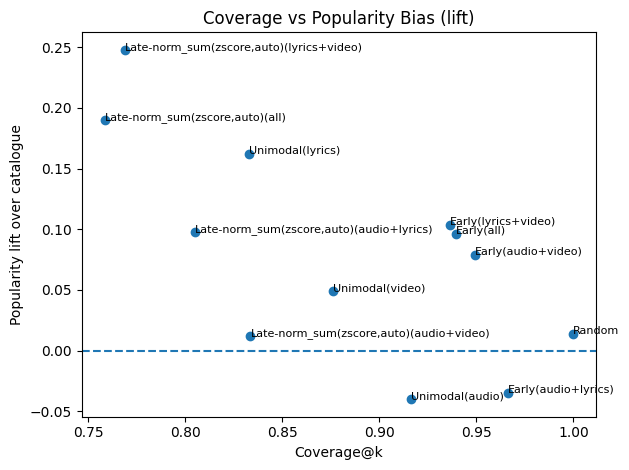

In [42]:
x = df_beyond["coverage"]
y = df_beyond["pop_lift"]

plt.figure()
plt.scatter(x, y)

for name, row in df_beyond.iterrows():
    plt.annotate(name, (row["coverage"], row["pop_lift"]), fontsize=8)

plt.xlabel("Coverage@k")
plt.ylabel("Popularity lift over catalogue")
plt.title("Coverage vs Popularity Bias (lift)")
plt.axhline(0, linestyle="--")  # lift=0 baseline
plt.tight_layout()

# save
out_path = os.path.join("eval_images", "coverage_vs_pop.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")

plt.show()

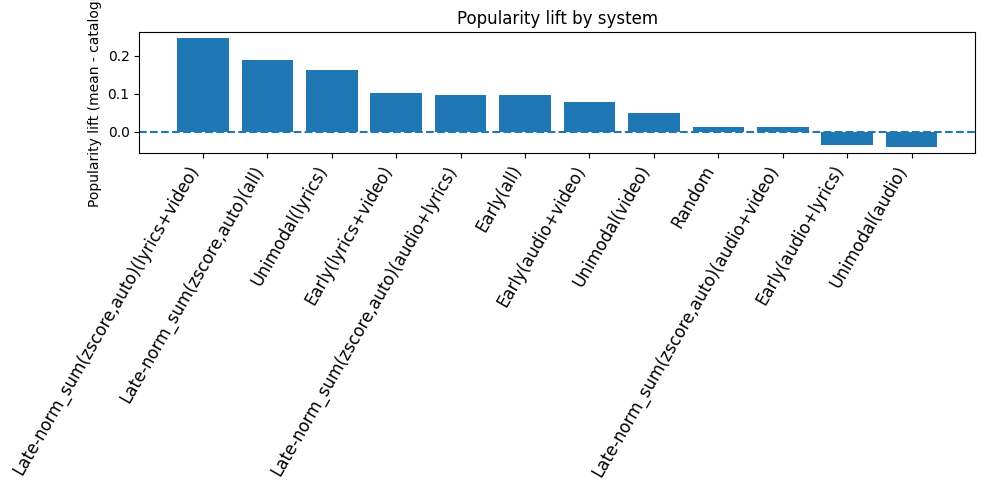

In [41]:
df_plot = df_beyond.sort_values("pop_lift", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_plot.index, df_plot["pop_lift"])
plt.axhline(0, linestyle="--")
plt.xticks(rotation=60, ha="right",  fontsize=12)
plt.ylabel("Popularity lift (mean - catalogue)")
plt.title("Popularity lift by system")
plt.tight_layout()

# save
out_path = os.path.join("eval_images", "poplift_by_system.png")
plt.savefig(out_path, dpi=500, bbox_inches="tight")


plt.show()



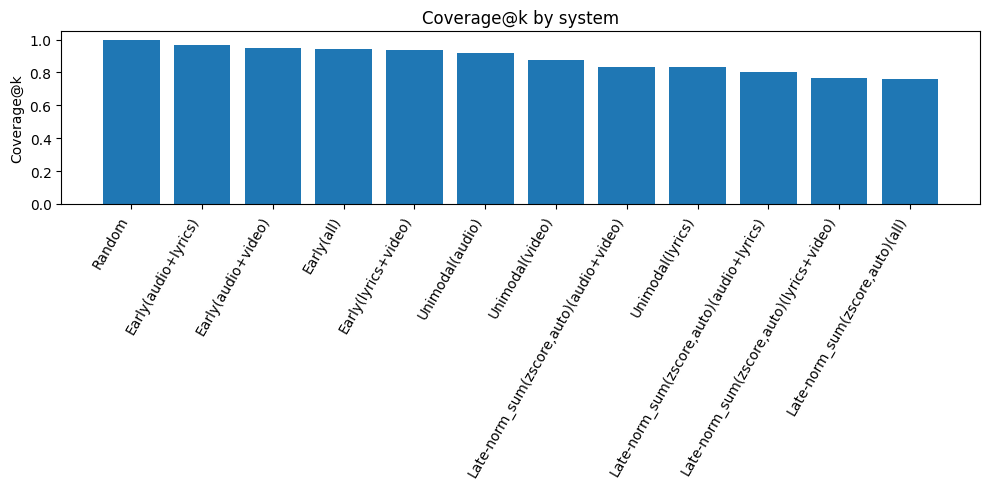

In [29]:

df_plot = df_beyond.sort_values("coverage", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df_plot.index, df_plot["coverage"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Coverage@k")
plt.title("Coverage@k by system")
plt.tight_layout()

# save
out_path = os.path.join("eval_images", "coverage_by_system.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")


plt.show()